### AI Calls My Tools!

**Introduction**

Many AI applications interact directly with humans. In these cases, it is appropriate for models to respond in natural language. But what about cases where we want a model to also interact directly with systems, such as databases or an API? These systems often have a particular input schema; for example, APIs frequently have a required payload structure. This need motivates the concept of tool calling. You can use tool calling to request model responses that match a particular schema.

*Note:* You will sometimes hear the term function calling. We use this term interchangeably with tool calling.

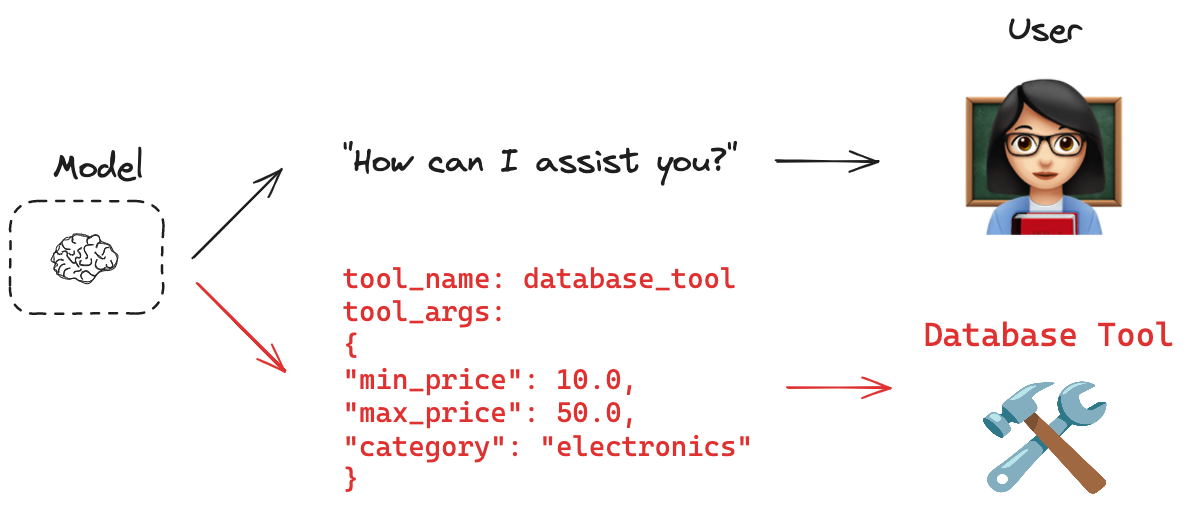

This demo will demonstrate how to use those tool cals to actually call a function and properly pass the results back to the model.

*Reference:* [How to pass tool outputs to chat models by LangChain](https://python.langchain.com/docs/how_to/tool_results_pass_to_model/)

*First*, just one dependency...

In [1]:
%pip install -qU langchain-openai

Note: you may need to restart the kernel to use updated packages.


Let's get OpenAI API token and select AI model to use.

In [2]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

Defining the simple tools we (AI) will use.

*References:*
- [Tools](https://python.langchain.com/docs/concepts/tools/)
- [Tool Calling](https://python.langchain.com/docs/concepts/tool_calling/)


In [3]:
from langchain_core.tools import tool


@tool
def add(a: int, b: int) -> int:
    """Adds a and b."""
    return a + b


@tool
def multiply(a: int, b: int) -> int:
    """Multiplies a and b."""
    return a * b


tools = [add, multiply]

llm_with_tools = llm.bind_tools(tools)

Now, let's get the model to call a tool. We'll add it to a list of messages that we'll treat as conversation history:

In [4]:
from langchain_core.messages import HumanMessage

query = "What is 3 * 12? Also, what is 11 + 49?"

messages = [HumanMessage(query)]

ai_msg = llm_with_tools.invoke(messages)

print(ai_msg.tool_calls)

messages.append(ai_msg)

[{'name': 'multiply', 'args': {'a': 3, 'b': 12}, 'id': 'call_3XdHFGiehEZKKNUm33oLJ7RQ', 'type': 'tool_call'}, {'name': 'add', 'args': {'a': 11, 'b': 49}, 'id': 'call_01GuDl2p7RPY0cwah7LCf3vF', 'type': 'tool_call'}]


Next let's invoke the tool functions using the args the model populated!

Conveniently, if we invoke a LangChain `Tool` with a `ToolCall`, we'll automatically get back a `ToolMessage` that can be fed back to the model:

In [5]:
for tool_call in ai_msg.tool_calls:
    selected_tool = {"add": add, "multiply": multiply}[tool_call["name"].lower()]
    tool_msg = selected_tool.invoke(tool_call)
    messages.append(tool_msg)

messages

[HumanMessage(content='What is 3 * 12? Also, what is 11 + 49?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3XdHFGiehEZKKNUm33oLJ7RQ', 'function': {'arguments': '{"a": 3, "b": 12}', 'name': 'multiply'}, 'type': 'function'}, {'id': 'call_01GuDl2p7RPY0cwah7LCf3vF', 'function': {'arguments': '{"a": 11, "b": 49}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 87, 'total_tokens': 137, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_6fc10e10eb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ef821b0b-1dee-4882-80d4-275e6dd4f44a-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 12}, 'id': 'call_3Xd

And finally, we'll invoke the model with the tool results. The model will use this information to generate a final answer to our original query:

In [6]:
llm_with_tools.invoke(messages)

AIMessage(content='The result of \\(3 \\times 12\\) is 36, and \\(11 + 49\\) equals 60.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 153, 'total_tokens': 181, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_6fc10e10eb', 'finish_reason': 'stop', 'logprobs': None}, id='run-ea2421d4-f41d-441b-9b28-08bc069b4de0-0', usage_metadata={'input_tokens': 153, 'output_tokens': 28, 'total_tokens': 181, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

Note that each `ToolMessage` must include a `tool_call_id` that matches an id in the original tool calls that the model generates. This helps the model match tool responses with tool calls.